In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

#import aparent.visualization as vis

#from aparent_predictor import *


Using TensorFlow backend.


In [2]:
#Store variant prediction dataframe

variant_df = pd.read_csv('aparent_resnet_variant_predictions_polyadb_no_sequences_no_cutoff.csv', sep='\t')


In [3]:
#Load APADB Data and filter on targeted genes

#genes = ['RUNX1', 'CEBPA', 'GATA2', 'ANKRD26', 'DDX41', 'ETV6', 'PTEN', 'BRCA1', 'BRCA2', 'TP53', 'APC', 'ATM', 'PALB2', 'MSH2', 'MLH1', 'MSH6', 'PMS2', 'MUTYH']

polyadb_df = pd.read_csv('polyadb_processed.csv', sep=',')

#polyadb_df = polyadb_df.loc[polyadb_df['gene'].isin(genes)].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[((~polyadb_df['gene'].isnull()) & (polyadb_df['gene'] != 'na')) & (polyadb_df['pas'] != -1)].reset_index(drop=True).copy()

print('len(polyadb_df) = ' + str(len(polyadb_df)))


len(polyadb_df) = 175451


In [4]:
#Process PolyaDB data

polyadb_df_minus = polyadb_df.query("strand == '-'").copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df.query("strand == '+'").copy().reset_index(drop=True)

polyadb_df_minus = polyadb_df_minus.sort_values(by='pas_pos', ascending=False).copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df_plus.sort_values(by='pas_pos', ascending=True).copy().reset_index(drop=True)

new_gene_id_list_plus = []
sitenum_list_plus = []
gene_id_dict = {}
for _, row in polyadb_df_plus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_plus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_plus.append(gene_id_dict[gene])

polyadb_df_plus['gene_id'] = new_gene_id_list_plus
polyadb_df_plus['sitenum'] = sitenum_list_plus

new_gene_id_list_minus = []
sitenum_list_minus = []
gene_id_dict = {}
for _, row in polyadb_df_minus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_minus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_minus.append(gene_id_dict[gene])

polyadb_df_minus['gene_id'] = new_gene_id_list_minus
polyadb_df_minus['sitenum'] = sitenum_list_minus

polyadb_df = pd.concat([polyadb_df_plus, polyadb_df_minus])

polyadb_df = polyadb_df.sort_values(by=['gene', 'sitenum'], ascending=True).reset_index(drop=True).copy()

In [5]:
#Get variant positions in hg38 coordinates

polyadb_bed_hg19 = pd.read_csv("polyadb_coordinates_hg19.bed", sep='\t', header=None, names=['chrom', 'pas_pos_hg19', 'end', 'gene', 'gene_id', 'strand'])
polyadb_bed_hg38 = pd.read_csv("polyadb_coordinates_hg38.bed", sep='\t', header=None, names=['chrom', 'pas_pos_hg38', 'end', 'gene', 'gene_id', 'strand'])

polyadb_bed_hg38 = polyadb_bed_hg38.join(polyadb_bed_hg19[['gene_id', 'pas_pos_hg19']].set_index('gene_id'), on='gene_id', how='inner').copy().reset_index(drop=True)

polyadb_bed_hg38['padb_join_id'] = polyadb_bed_hg38['chrom'] + "_" + polyadb_bed_hg38['pas_pos_hg19'].astype(str) + "_" + polyadb_bed_hg38['gene']
polyadb_df['padb_join_id'] = polyadb_df['chrom'] + "_" + polyadb_df['pas_pos'].astype(str) + "_" + polyadb_df['gene']

polyadb_df = polyadb_df.join(polyadb_bed_hg38[['padb_join_id', 'pas_pos_hg38']].set_index("padb_join_id"), on='padb_join_id', how='inner').copy().reset_index(drop=True)

#polyadb_df = polyadb_df.query("site_type == '3_most_exon'")

polyadb_df = polyadb_df.drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)

variant_df = variant_df.join(polyadb_df[['gene_id', 'pas_pos', 'pas_pos_hg38']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)

variant_df['var_position_hg38'] = variant_df['var_position'] - variant_df['pas_pos'] + variant_df['pas_pos_hg38']


In [4]:
#Store hg19 interval of PAS sites to intersect UKBB data against

polyadb_df['start'] = polyadb_df['pas_pos'] - 150
polyadb_df['end'] = polyadb_df['pas_pos'] + 150

polyadb_bed = polyadb_df[['chrom', 'start', 'end', 'gene', 'gene_id', 'strand']].query("chrom != 'chrX' and chrom != 'chrY'").copy().reset_index(drop=True)

polyadb_bed['sort_chrom'] = polyadb_bed['chrom'].apply(lambda x: x[3:]).astype(int)
polyadb_bed['sort_start'] = polyadb_bed['start'].astype(int)

polyadb_bed = polyadb_bed.sort_values(by=['sort_chrom', 'sort_start'], ascending=True).copy().reset_index(drop=True)

polyadb_bed = polyadb_bed[['chrom', 'start', 'end', 'gene', 'gene_id', 'strand']].copy().reset_index(drop=True)

polyadb_bed.to_csv("polyadb_interval_coordinates_hg19.sorted.bed", sep='\t', header=False, index=False)


In [5]:
#Intersect UKBB data against PolyADB

!bedtools intersect -sorted -a polyadb_interval_coordinates_hg19.sorted.bed -b UKBB_94_traits/UKBB_94traits_release1_regions.bed.gz -wb > UKBB_94_traits/UKBB_94traits_release1_regions_intersect.bed


In [6]:
#Get UKBB fine-mapping data

column_names = [
    'chromosome',
    'start',
    'end',
    'variant',
    'rsid',
    'allele1',
    'allele2',
    'minorallele',
    'cohort',
    'model_marginal',
    'method',
    'trait',
    'region',
    'maf',
    'beta_marginal',
    'se_marginal',
    'chisq_marginal',
    'pip',
    'cs_id',
    'beta_posterior',
    'sd_posterior',
    'LD_HWE',
    'LD_SV',
]

ukbb_df = pd.read_csv("UKBB_94_traits/UKBB_94traits_release1.bed.gz", sep='\t', compression='gzip', names=column_names)

print("len(ukbb_df) = " + str(len(ukbb_df)))


len(ukbb_df) = 5377879


In [7]:
#Get UKKB non-causal variants

column_names = [
    'chromosome',
    'start',
    'end',
    'cohort',
    'trait',
    'region',
    'variant',
    'success_finemap',
    'success_susie',
]

all_ukbb_df = pd.read_csv("UKBB_94_traits/UKBB_94traits_release1_regions_intersect.bed", sep='\t', names=column_names)

#Apply filters
all_ukbb_df = all_ukbb_df.query("success_finemap == True and success_susie == True").drop_duplicates(subset=['variant', 'trait', 'cohort'], keep='first').copy().reset_index(drop=True)

print("len(all_ukbb_df) = " + str(len(all_ukbb_df)))


len(all_ukbb_df) = 3450965


In [9]:
#Extract non-causal variants

all_ukbb_df = all_ukbb_df[['chromosome', 'start', 'end', 'cohort', 'trait', 'region', 'variant']]

all_ukbb_df = all_ukbb_df.join(ukbb_df[['variant', 'pip']].set_index("variant"), on='variant', how='left')
noncausal_ukbb_df = all_ukbb_df.loc[all_ukbb_df['pip'].isnull()].copy().reset_index(drop=True)
noncausal_ukbb_df['pip'] = 0.


In [8]:
#Map variants to predictions

variant_df['ukbb_join_id'] = variant_df['chrom'] + ":" + variant_df['var_position'].astype(str) + ":" + variant_df['ref_nucleotide'] + ":" + variant_df['var_nucleotide']

variant_df_gwas = variant_df.join(ukbb_df[["variant", 'rsid', 'trait', 'maf', 'pip', 'cs_id', 'beta_marginal', 'se_marginal', 'chisq_marginal', 'beta_posterior', 'sd_posterior']].set_index("variant"), on='ukbb_join_id', how='inner').copy().reset_index(drop=True)

variant_df_gwas.to_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_ukbb_no_cutoff_w_chisq.csv", sep='\t', index=False)

#Map non-causal variants to predictions

variant_df_gwas_noncausal = variant_df.join(noncausal_ukbb_df[["variant", 'trait', 'pip']].set_index("variant"), on='ukbb_join_id', how='inner').copy().reset_index(drop=True)

variant_df_gwas_noncausal.to_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_ukbb_noncausal_no_cutoff.csv", sep='\t', index=False)


'\nvariant_df_gwas_noncausal = variant_df.join(noncausal_ukbb_df[["variant", \'trait\', \'pip\']].set_index("variant"), on=\'ukbb_join_id\', how=\'inner\').copy().reset_index(drop=True)\n\nvariant_df_gwas_noncausal.to_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_ukbb_noncausal_no_cutoff.csv", sep=\'\t\', index=False)\n'

In [9]:

variant_df_gwas = pd.read_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_ukbb_no_cutoff_w_chisq.csv", sep='\t')
variant_df_gwas_noncausal = pd.read_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_ukbb_noncausal_no_cutoff.csv", sep='\t')


In [10]:
#Drop duplicates for partially overlapping annotated PASs

variant_df_gwas['rsID'] = variant_df_gwas['rsid'].astype(str)

variant_df_gwas['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas['delta_logodds_77_127'])

variant_df_gwas['rel_var_position'] = -1
variant_df_gwas.loc[variant_df_gwas['strand'] == '+', 'rel_var_position'] = variant_df_gwas['var_position'] - (variant_df_gwas['pas_pos'] - 70 + 1)
variant_df_gwas.loc[variant_df_gwas['strand'] == '-', 'rel_var_position'] = ((variant_df_gwas['pas_pos'] - (205 - 70)) + 205) - variant_df_gwas['var_position']

variant_df_gwas['target_rel_var_position'] = np.abs(90 - variant_df_gwas['rel_var_position'])
variant_df_gwas['delta_logodds_77_127_abs'] = -variant_df_gwas['delta_logodds_77_127_abs']
variant_df_gwas = variant_df_gwas.sort_values(by=['target_rel_var_position', 'delta_logodds_77_127_abs'], ascending=True).drop_duplicates(subset=['ukbb_join_id', 'trait'], keep='first').copy().reset_index(drop=True)


In [11]:
#Aggregate summary statistic for unique SNPs (by rsID)

variant_df_gwas_lead = variant_df_gwas.copy().sort_values(by='pip', ascending=False).drop_duplicates("ukbb_join_id").copy().reset_index(drop=True)

print("len(variant_df_gwas_lead) = " + str(len(variant_df_gwas_lead)))


len(variant_df_gwas_lead) = 17426


In [12]:
#Filter on 3' UTR SNPs only

variant_df_gwas = variant_df_gwas.query("site_type == '3_most_exon'").copy().reset_index(drop=True)
variant_df_gwas_lead = variant_df_gwas_lead.query("site_type == '3_most_exon'").copy().reset_index(drop=True)


n = 9190
n (>= 1.4-fold) = 1153

n = 41 (PP >= 0.9)
n (>= 1.4-fold) = 13 (PP >= 0.9)


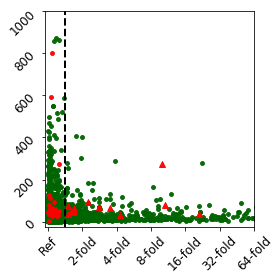

In [26]:

f = plt.figure(figsize=(4, 4))

variant_df_gwas_lead['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas_lead['delta_logodds_77_127'])

variant_df_gwas_lead_non_signi = variant_df_gwas_lead.query("pip < 0.9")
variant_df_gwas_lead_signi = variant_df_gwas_lead.query("pip >= 0.9")

print("n = " + str(len(variant_df_gwas_lead)))
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead.query("delta_logodds_77_127_abs >= 0.336"))))

print("")
print("n = " + str(len(variant_df_gwas_lead_signi)) + " (PP >= 0.9)")
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336"))) + " (PP >= 0.9)")

plt.scatter(variant_df_gwas_lead_non_signi['delta_logodds_77_127_abs'] / np.log(2.), variant_df_gwas_lead_non_signi['chisq_marginal'], color='darkgreen', s=15, alpha=0.95)

plt.scatter(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs < 0.336")['delta_logodds_77_127_abs'] / np.log(2.), variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs < 0.336")['chisq_marginal'], color='red', s=15, alpha=0.95)
plt.scatter(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336")['delta_logodds_77_127_abs'] / np.log(2.), variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336")['chisq_marginal'], color='red', s=35, marker="^", alpha=0.95)

plt.axvline(x=np.log2(1.4), linestyle='--', linewidth=2, color='black')

plt.xlim(-0.1, 6.0)
plt.ylim(-25, 1000)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Ref', '2-fold', '4-fold', '8-fold', '16-fold', '32-fold', '64-fold'], fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=45)

plt.savefig("ukbb_aparent_resnet_scatter_utr3_only_pp_09_v2.png", transparent=True, dpi=300)
plt.savefig("ukbb_aparent_resnet_scatter_utr3_only_pp_09_v2.eps")

plt.tight_layout()

plt.show()


n = 9190
n (>= 1.4-fold) = 1153

n = 26 (PP >= 0.5)
n (>= 1.4-fold) = 2 (PP >= 0.5)

n = 41 (PP >= 0.9)
n (>= 1.4-fold) = 13 (PP >= 0.9)


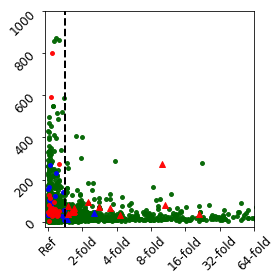

In [27]:

f = plt.figure(figsize=(4, 4))

variant_df_gwas_lead['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas_lead['delta_logodds_77_127'])

variant_df_gwas_lead_non_signi = variant_df_gwas_lead.query("pip < 0.5")
variant_df_gwas_lead_semi_signi = variant_df_gwas_lead.query("pip >= 0.5 and pip < 0.9")
variant_df_gwas_lead_signi = variant_df_gwas_lead.query("pip >= 0.9")

print("n = " + str(len(variant_df_gwas_lead)))
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead.query("delta_logodds_77_127_abs >= 0.336"))))

print("")
print("n = " + str(len(variant_df_gwas_lead_semi_signi)) + " (PP >= 0.5)")
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead_semi_signi.query("delta_logodds_77_127_abs >= 0.336"))) + " (PP >= 0.5)")

print("")
print("n = " + str(len(variant_df_gwas_lead_signi)) + " (PP >= 0.9)")
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336"))) + " (PP >= 0.9)")

plt.scatter(variant_df_gwas_lead_non_signi['delta_logodds_77_127_abs'] / np.log(2.), variant_df_gwas_lead_non_signi['chisq_marginal'], color='darkgreen', s=15, alpha=0.95)

plt.scatter(variant_df_gwas_lead_semi_signi.query("delta_logodds_77_127_abs < 0.336")['delta_logodds_77_127_abs'] / np.log(2.), variant_df_gwas_lead_semi_signi.query("delta_logodds_77_127_abs < 0.336")['chisq_marginal'], color='blue', s=15, alpha=0.95)
plt.scatter(variant_df_gwas_lead_semi_signi.query("delta_logodds_77_127_abs >= 0.336")['delta_logodds_77_127_abs'] / np.log(2.), variant_df_gwas_lead_semi_signi.query("delta_logodds_77_127_abs >= 0.336")['chisq_marginal'], color='blue', s=35, marker="^", alpha=0.95)

plt.scatter(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs < 0.336")['delta_logodds_77_127_abs'] / np.log(2.), variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs < 0.336")['chisq_marginal'], color='red', s=15, alpha=0.95)
plt.scatter(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336")['delta_logodds_77_127_abs'] / np.log(2.), variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336")['chisq_marginal'], color='red', s=35, marker="^", alpha=0.95)

plt.axvline(x=np.log2(1.4), linestyle='--', linewidth=2, color='black')

plt.xlim(-0.1, 6.0)
plt.ylim(-25, 1000)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Ref', '2-fold', '4-fold', '8-fold', '16-fold', '32-fold', '64-fold'], fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=45)

plt.savefig("ukbb_aparent_resnet_scatter_utr3_only_pp_05_09_v2.png", transparent=True, dpi=300)
plt.savefig("ukbb_aparent_resnet_scatter_utr3_only_pp_05_09_v2.eps")

plt.tight_layout()

plt.show()


In [28]:
#Load trait metadata

ukbb_meta_df = pd.read_csv("UKBB_94_traits/UKBB_94traits_release1.traits", sep='\t')


In [29]:
#Get SNPs with PP >= 0.5 and PP >= 0.9

variant_df_gwas_semi_signi = variant_df_gwas.query("pip >= 0.5 and pip < 0.9").copy()
variant_df_gwas_lead_semi_signi = variant_df_gwas_lead_semi_signi.query("pip >= 0.5 and pip < 0.9").copy()

variant_df_gwas_semi_signi = variant_df_gwas_semi_signi.join(ukbb_meta_df[['trait', 'description']].set_index("trait"), on='trait', how='inner').copy().reset_index(drop=True)
variant_df_gwas_lead_semi_signi = variant_df_gwas_lead_semi_signi.join(ukbb_meta_df[['trait', 'description']].set_index("trait"), on='trait', how='inner').copy().reset_index(drop=True)

variant_df_gwas_signi = variant_df_gwas.query("pip >= 0.9").copy()
variant_df_gwas_lead_signi = variant_df_gwas_lead_signi.query("pip >= 0.9").copy()

variant_df_gwas_signi = variant_df_gwas_signi.join(ukbb_meta_df[['trait', 'description']].set_index("trait"), on='trait', how='inner').copy().reset_index(drop=True)
variant_df_gwas_lead_signi = variant_df_gwas_lead_signi.join(ukbb_meta_df[['trait', 'description']].set_index("trait"), on='trait', how='inner').copy().reset_index(drop=True)

variant_df_gwas_lead_semi_signi['delta_logodds_77_127_abs_log_2'] = 2**(variant_df_gwas_lead_semi_signi['delta_logodds_77_127_abs'] / np.log(2.))
variant_df_gwas_lead_signi['delta_logodds_77_127_abs_log_2'] = 2**(variant_df_gwas_lead_signi['delta_logodds_77_127_abs'] / np.log(2.))


In [30]:
#Get variant ids

rs_ids = set(variant_df_gwas['rsID'].unique().tolist())

rs_ids_semi_signi = set(variant_df_gwas_semi_signi['rsID'].unique().tolist())
rs_ids_lead_semi_signi = set(variant_df_gwas_lead_semi_signi['rsID'].unique().tolist())

rs_ids_signi = set(variant_df_gwas_signi['rsID'].unique().tolist())
rs_ids_lead_signi = set(variant_df_gwas_lead_signi['rsID'].unique().tolist())


In [31]:
#Top candidates from CasualDB with PP >= 0.9 (cutoff immediately after known pathogenic variant rs1799963)

cand_rs_ids = variant_df_gwas_lead_signi.sort_values(by='delta_logodds_77_127_abs_log_2', ascending=False).query("delta_logodds_77_127_abs_log_2 >= 1.4")['rsID'].values.tolist()

print("--- SNPs from credible set w. PP >= 0.9 ---")

for cand_rs_id in cand_rs_ids :
    print((cand_rs_id + " " * 15)[:15] + ": " + str((cand_rs_id in rs_ids_signi)))
    
    if cand_rs_id in rs_ids_signi :
        print(" - delta_logodds_77_127 = " + str(round(variant_df_gwas_lead_signi.query("rsID == '" + cand_rs_id + "'").iloc[0]['delta_logodds_77_127'], 4)))
        print(" - delta_logodds_77_127_abs_log_2 = " + str(round(2**(np.abs(variant_df_gwas_lead_signi.query("rsID == '" + cand_rs_id + "'").iloc[0]['delta_logodds_77_127']) / np.log(2.)), 4)))
        
        subset_df = variant_df_gwas_signi.query("rsID == '" + cand_rs_id + "'")
        for _, row in subset_df.iterrows() :
            print(" -- " + row['description'] + ", statistic = " + str(row['chisq_marginal']) + ", PP = " + str(row['pip']))

        print("")


--- SNPs from credible set w. PP >= 0.9 ---
rs3211995      : True
 - delta_logodds_77_127 = 3.0457
 - delta_logodds_77_127_abs_log_2 = 21.0241
 -- Mean arterial pressure, statistic = 37.9865, PP = 0.996894
 -- Systolic blood pressure, statistic = 43.1158, PP = 0.995952

rs78378222     : True
 - delta_logodds_77_127 = -2.3624
 - delta_logodds_77_127_abs_log_2 = 10.6162
 -- Adult height, statistic = 118.362, PP = 1.0
 -- Mean corpuscular hemoglobin, statistic = 100.5, PP = 1.0
 -- Mean corpuscular volume, statistic = 88.3365, PP = 1.0
 -- Red blood cell count, statistic = 97.3022, PP = 1.0
 -- Apolipoprotein A, statistic = 40.8586, PP = 0.926956
 -- Diastolic blood pressure, statistic = 43.0585, PP = 1.0
 -- Loss of Y, statistic = 296.598, PP = 1.0
 -- Body weight, statistic = 77.2636, PP = 1.0
 -- Hematocrit, statistic = 23.3951, PP = 0.902121
 -- Pluse pressure, statistic = 90.6262, PP = 1.0

rs6796         : True
 - delta_logodds_77_127 = -2.2975
 - delta_logodds_77_127_abs_log_2 = 9.

In [32]:
#Top candidates from CasualDB with PP >= 0.5 (cutoff immediately after known pathogenic variant rs1799963)

cand_rs_ids = variant_df_gwas_lead_semi_signi.sort_values(by='delta_logodds_77_127_abs_log_2', ascending=False).query("delta_logodds_77_127_abs_log_2 >= 1.4")['rsID'].values.tolist()

print("--- SNPs from credible set w. PP >= 0.5 ---")

for cand_rs_id in cand_rs_ids :
    print((cand_rs_id + " " * 15)[:15] + ": " + str((cand_rs_id in rs_ids_semi_signi)))
    
    if cand_rs_id in rs_ids_semi_signi :
        print(" - delta_logodds_77_127 = " + str(round(variant_df_gwas_lead_semi_signi.query("rsID == '" + cand_rs_id + "'").iloc[0]['delta_logodds_77_127'], 4)))
        print(" - delta_logodds_77_127_abs_log_2 = " + str(round(2**(np.abs(variant_df_gwas_lead_semi_signi.query("rsID == '" + cand_rs_id + "'").iloc[0]['delta_logodds_77_127']) / np.log(2.)), 4)))
        
        subset_df = variant_df_gwas_semi_signi.query("rsID == '" + cand_rs_id + "'")
        for _, row in subset_df.iterrows() :
            print(" -- " + row['description'] + ", statistic = " + str(row['chisq_marginal']) + ", PP = " + str(row['pip']))

        print("")


--- SNPs from credible set w. PP >= 0.5 ---
rs1064939      : True
 - delta_logodds_77_127 = 0.9162
 - delta_logodds_77_127_abs_log_2 = 2.4999
 -- Body mass index, statistic = 41.7335, PP = 0.894186

rs45463895     : True
 - delta_logodds_77_127 = -0.3893
 - delta_logodds_77_127_abs_log_2 = 1.4759
 -- Monocyte count, statistic = 11.1444, PP = 0.679254

